### This notebook is used for creating the dataset of real guppies images to test the YOLO model on

In [1]:
import os
from google.cloud import vision

import pickle
import h5py

import numpy as np
import matplotlib.pyplot as plt
import random

# Our scripts
from Python_Helpers.image_loading import * 
from Python_Helpers.preprocessing import * 
from Python_Helpers.corrections import *
from Python_Helpers.ID_isolation import *
from Python_Helpers.YOLO import *
from Python_Helpers.ML_helper import *


os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"./guppies-test-4c48569421d8.json"

relevant_characters =  {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'B',10:'F',11:'G',12:'K',13:'N',14:'O',15:'P',16:'R',17:'S',18:'V',19:'W',20:'Y', 21:''}

client = vision.ImageAnnotatorClient()

In [2]:
### DON'T RERUN ###

# # Code that split the Manually_Labelled/New files into training and testing data.

# training_files = ListAvaliableFiles('guppy_images', prefix='Manually_Labelled/New', verbose=True)
# random.shuffle(training_files)

# train_files = training_files[:70000]
# test_files = training_files[70000:]

# with open('ML_Data/training_files.dat', 'wb') as writer:
#     pickle.dump(train_files, writer)

# with open('ML_Data/testing_files.dat', 'wb') as writer:
#     pickle.dump(test_files, writer)

In [3]:
# Load the training and testing data files (should have lengths 70000 and 28474 respectively).

with open('ML_Data/training_files.dat', 'rb') as reader:
    training_files = pickle.load(reader)

with open('ML_Data/testing_files.dat', 'rb') as reader:
    testing_files = pickle.load(reader)

len(training_files), len(testing_files)

(70000, 28474)

In [4]:
# Function returns just the ID image. Can be used to check the ID_isolation process.
def ImageFunction(image_in_bytes, padx=80, pady=20, delta_width=10, verbose=False):
    # Initial google read and preprocessing of image.
    Initial_Results = GoogleRead(image_in_bytes, verbose=verbose)
    Processed_Results, title, ID, date = PreprocessLabel(Initial_Results, verbose=verbose)

    # Corrected google prediction.
    title, ID, date = CorrectOutput(title, ID, date)

    # Identity isolation
    ID_Dictionary = IsolateIdentity(Processed_Results, padx=padx, pady=pady, delta_width=delta_width, verbose=verbose)

    return '-'.join([title, ID, date]), ID_Dictionary['frame']


def extract_ID(training_files):
    #extract the IDs from the filenames.
    
    id_list = []
    for f in training_files:
        f = f.split('/')[-1].split('.')[0]
        
        if 's' in f:
            f = f.split('s')[0]

        if '(' in f: #this is something where the file has a (1) in it.
            f = f.split('(')[0][:-1]
            
        title = f[:3]
        date = f[-4:]
        id = f[3:-4]
        id_list.append(id)

    return id_list

IDs = np.array(extract_ID(training_files))

maxlen = np.max([len(IDs[i]) for i in range(len(IDs))])

c:\Users\newc6448\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


2B6P 2B6P


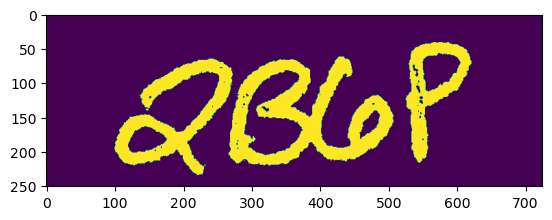

In [5]:
i=0
file = training_files[i]
image_in_bytes = RetreiveImageGoogle('guppy_images', file)
google_prediction, ID_image = ImageFunction(image_in_bytes, verbose=False)

google_prediction = google_prediction.split('-')[1]

plt.imshow(ID_image)
print(google_prediction, IDs[i])

In [6]:
string_to_vector(IDs[i], relevant_characters, max_len=maxlen), IDs[i]

(array([ 2,  9,  6, 15, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21]),
 '2B6P')

In [7]:
h5f = h5py.File(('ML_Data/dataset.h5'), 'w')

ID_image_width, ID_image_height = 256, 64

file = training_files[0]

image_in_bytes = RetreiveImageGoogle('guppy_images', file)

google_prediction, ID_image = ImageFunction(image_in_bytes, verbose=False)

label_ID = IDs[0]

first_ID_image = preprocess_image(ID_image[...,None],(ID_image_width,ID_image_height)).numpy()[None,...,0]
first_label = string_to_vector(label_ID, relevant_characters,max_len=maxlen)[None]
first_label_googpred = string_to_vector(google_prediction.split('-')[1], relevant_characters,max_len=maxlen)[None]

h5f.create_dataset('ID_images', data=first_ID_image, compression="gzip", chunks=True, maxshape=(None,ID_image_height,ID_image_width))
h5f.create_dataset('labels', data=first_label, compression="gzip", chunks=True, maxshape=(None,maxlen))
h5f.create_dataset('labels_googpred', data=first_label_googpred, compression="gzip", chunks=True, maxshape=(None,maxlen))

<HDF5 dataset "labels_googpred": shape (1, 26), type "<i4">

In [8]:
training_files = training_files[:15000]

some_im_IDs = []
some_label_IDs = []

idx = np.arange(0, len(training_files))
np.random.shuffle(idx)


for i in range(len(training_files)):
    st = str(i)
    try: 
        image_in_bytes = RetreiveImageGoogle('guppy_images', training_files[idx[i]])

        google_prediction, ID_image = ImageFunction(image_in_bytes, verbose=False)

        image = preprocess_image(ID_image[...,None],(ID_image_width,ID_image_height))[None,...,0]
        label = string_to_vector(IDs[idx[i]], relevant_characters, max_len=maxlen)[None]
        label_goog = string_to_vector(google_prediction.split('-')[1], relevant_characters, max_len=maxlen)[None]
        
        h5f['ID_images'].resize((h5f['ID_images'].shape[0] + 1),axis=0)
        h5f['ID_images'][-1:] = image

        h5f['labels'].resize((h5f['labels'].shape[0] + 1),axis=0)
        h5f['labels'][-1:] = label

        h5f['labels_googpred'].resize((h5f['labels_googpred'].shape[0] + 1),axis=0)
        h5f['labels_googpred'][-1:] = label_goog


        st += ' success'

    except: st += ' fail'
    print(st)

i = 0
print(f"a success rate of {len(h5f['ID_images']) / (len(training_files)+1)  * 100} %")

0 success
1 success
2 success
3 success
4 success
5 success
6 success
7 success
8 success
9 success
10 success
11 success
12 success
13 success
14 success
15 success
16 success
17 success
18 success
19 success
20 success
21 success
22 success
23 success
24 success
25 success
26 success
27 success
28 success
29 success
30 success
31 success
32 success
33 success
34 success
35 success
36 success
37 success
38 success
39 success
40 success
41 success
42 success
43 success
44 success
45 success
46 success
47 success
48 success
49 success
50 success
51 success
52 success
53 success
54 success
55 success
56 success
57 success
58 success
59 success
60 success
61 success
62 success
63 success
64 success
65 success
66 success
67 success
68 success
69 success
70 success
71 success
72 success
73 success
74 success
75 fail
76 success
77 success
78 fail
79 fail
80 success
81 success
82 success
83 success
84 success
85 success
86 success
87 success
88 success
89 success
90 success
91 success
92 succ

c:\Users\newc6448\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\newc6448\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


9351 fail
9352 success
9353 success
9354 success
9355 fail
9356 success
9357 success
9358 success
9359 success
9360 success
9361 success
9362 success
9363 success
9364 success
9365 success
9366 success
9367 success
9368 success
9369 success
9370 success
9371 success
9372 success
9373 success
9374 success
9375 success
9376 success
9377 success
9378 success
9379 success
9380 success
9381 success
9382 success
9383 success
9384 success
9385 success
9386 success
9387 success
9388 success
9389 success
9390 fail
9391 success
9392 success
9393 success
9394 success
9395 success
9396 success
9397 success
9398 success
9399 success
9400 success
9401 success
9402 success
9403 success
9404 success
9405 success
9406 success
9407 success
9408 success
9409 success
9410 success
9411 success
9412 success
9413 success
9414 fail
9415 success
9416 success
9417 success
9418 success
9419 success
9420 success
9421 success
9422 success
9423 success
9424 success
9425 success
9426 success
9427 success
9428 fail
9

Text(0.5, 1.0, 'Google Prediction: 1B5F\nCorrect Prediction:1B5F')

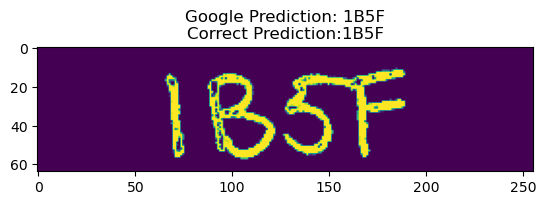

In [29]:
# Check the data in the data set for a random index
h5f = h5py.File(('ML_Data/dataset.h5'), 'r')
random_index = random.choice(range(len(h5f['ID_images'])))

google_pred = ''.join(vector_to_string(h5f['labels_googpred'][random_index], relevant_characters))
correct = ''.join(vector_to_string(h5f['labels'][random_index], relevant_characters))

plt.imshow(h5f['ID_images'][random_index])
plt.title('Google Prediction: ' + google_pred + '\nCorrect Prediction:' + correct)